<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

data = pd.read_csv('preprocessed_data.csv', nrows = 50000)

In [ ]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sid = SentimentIntensityAnalyzer()
negative, positive, neutral, compound = [], [], [], []
for review in tqdm(data['essay']):
    ss = sid.polarity_scores(review)
    negative.append(ss['neg'])
    positive.append(ss['pos'])
    neutral.append(ss['neu'])
    compound.append(ss['compound'])

100%|██████████| 50000/50000 [01:13<00:00, 675.98it/s]


In [ ]:
data['positive'] = positive
data['negative'] = negative
data['neutral'] = neutral
data['compound'] = compound

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data['project_is_approved'],stratify = data['project_is_approved'], test_size=0.33)
print(X_train.shape)

(33500, 13)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### Vectorizing essay

### i) TFIDF

In [ ]:
#TF-IDF of essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,4))

vectorizer.fit(X_train['essay'].values)
essay_tfidf_train = vectorizer.transform(X_train['essay'])
essay_tfidf_test = vectorizer.transform(X_test['essay'])


In [ ]:
(essay_tfidf_train).shape

(33500, 110313)

### ii) TFIDF W2V

In [ ]:
import numpy as np
from tqdm import tqdm
def word2vec(f):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(f): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words):
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

In [ ]:
essay_w2v_train = np.array(word2vec(X_train['essay']))
essay_w2v_test = np.array(word2vec(X_test['essay']))


100%|██████████| 16500/16500 [00:03<00:00, 4374.04it/s]


In [ ]:
(essay_w2v_train).shape

(33500, 300)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

## response encoding on categorical features 

In [ ]:
X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'positive',
       'negative', 'neutral', 'compound'],
      dtype='object')

In [ ]:
#referred https://github.com/roothd17/Donor-Choose-ML/blob/master/Donor%20Choose%20RF%20and%20GBDT.ipynb
#and tweaked a little for improvements

def Response_table(feature, df):
    alpha = 1 #used for laplace smoothing
    count = X_train[feature].value_counts()    
    featDict = dict()
    for i, denominator in count.items():
        vec = []
        for j in range(0,2):  # itearte 2 times for 2 classes - 0,1
            cls_cnt = X_train.loc[(X_train['project_is_approved'] == j) & (X_train[feature] == i)]            
            vec.append((cls_cnt.shape[0] + alpha*10 ) / (denominator + 90 * alpha))
        featDict[i] = vec # we are adding the feature to the dict as key and vec as value
    return featDict

# when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
# (numerator + 10 *alpha) / (denominator + 90 *alpha ) 

def Response_encoding(col, df):
    featureDict = Response_table(col, df ) 
    count = X_train[col].value_counts()
    feature = []
    for index, row in df.iterrows():
        if row[col] in dict(count).keys():
            feature.append(featureDict[row[col]] )
        else:
            feature.append([0.5, 0.5])
    return feature

In [ ]:
X_train_state = np.array(Response_encoding("school_state", X_train))
X_test_state = np.array(Response_encoding("school_state", X_test))

In [ ]:
print(X_train_state.shape)
print(X_test_state.shape)

(33500, 2)
(16500, 2)


In [ ]:
X_train_teachpre = np.array(Response_encoding("teacher_prefix", X_train))
X_test_teachpre = np.array(Response_encoding("teacher_prefix", X_test))


In [ ]:
print(X_train_teachpre.shape)
print(X_test_teachpre.shape)

(33500, 2)
(16500, 2)


In [ ]:
X_train_category = np.array(Response_encoding("clean_categories", X_train))
X_test_category = np.array(Response_encoding("clean_categories", X_test))

In [ ]:
print(X_train_category.shape)
print(X_test_category.shape)

(33500, 2)
(16500, 2)


In [ ]:
X_train_subcategory = np.array(Response_encoding("clean_subcategories", X_train))
X_test_subcategory = np.array(Response_encoding("clean_subcategories", X_test))


In [ ]:
print(X_train_subcategory.shape)
print(X_test_subcategory.shape)

(33500, 2)
(16500, 2)


In [ ]:
X_train_grade = np.array(Response_encoding("project_grade_category", X_train))
X_test_grade = np.array(Response_encoding("project_grade_category", X_test))


In [ ]:
print(X_train_grade.shape)
print(X_test_grade.shape)

(33500, 2)
(16500, 2)


In [ ]:
#normalizing the numerical features
from sklearn.preprocessing import Normalizer
nz = Normalizer()

nz.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_proj_nz_train = nz.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_proj_nz_test = nz.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

nz.fit(X_train['price'].values.reshape(-1,1))
price_nz_train = nz.transform(X_train['price'].values.reshape(-1,1))
price_nz_test = nz.transform(X_test['price'].values.reshape(-1,1))


nz.fit(X_train['negative'].values.reshape(-1,1))
negative_nz_train = nz.transform(X_train['negative'].values.reshape(-1,1))
negative_nz_test = nz.transform(X_test['negative'].values.reshape(-1,1))


nz.fit(X_train['positive'].values.reshape(-1,1))
positive_nz_train = nz.transform(X_train['positive'].values.reshape(-1,1))
positive_nz_test = nz.transform(X_test['positive'].values.reshape(-1,1))


nz.fit(X_train['neutral'].values.reshape(-1,1))
neutral_nz_train = nz.transform(X_train['neutral'].values.reshape(-1,1))
neutral_nz_test = nz.transform(X_test['neutral'].values.reshape(-1,1))


nz.fit(X_train['compound'].values.reshape(-1,1))
compound_nz_train = nz.transform(X_train['compound'].values.reshape(-1,1))
compound_nz_test = nz.transform(X_test['compound'].values.reshape(-1,1))

In [ ]:
type(neutral_nz_train)

numpy.ndarray

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
from scipy.sparse import hstack
X_tfidf_train = hstack((essay_tfidf_train, X_train_state, X_train_teachpre, X_train_grade, X_train_category, 
                        X_train_subcategory, prev_proj_nz_train, price_nz_train, negative_nz_train,positive_nz_train, 
                        neutral_nz_train, compound_nz_train)).tocsr()


In [ ]:
print((essay_tfidf_train).shape, 
                      X_train_state.shape, 
                      X_train_teachpre.shape, 
                      X_train_grade.shape, 
                      X_train_category.shape, 
                      X_train_subcategory.shape, 
                      prev_proj_nz_train.shape, 
                      price_nz_train.shape, 
                      negative_nz_train.shape,
                      positive_nz_train.shape, 
                      neutral_nz_train.shape, 
                      compound_nz_train.shape)

(33500, 110313) (33500, 2) (33500, 2) (33500, 2) (33500, 2) (33500, 2) (33500, 1) (33500, 1) (33500, 1) (33500, 1) (33500, 1) (33500, 1)


In [ ]:
X_tfidf_test = hstack((essay_tfidf_test, X_test_state, X_test_teachpre, X_test_grade, X_test_category, 
                       X_test_subcategory, prev_proj_nz_test, price_nz_test, negative_nz_test, positive_nz_test, 
                       neutral_nz_test, compound_nz_test)).tocsr()

In [ ]:
from scipy.sparse import hstack
import scipy.sparse as sp
X_w2v_train = hstack((sp.csr_matrix(essay_w2v_train),X_train_state, X_train_teachpre, X_train_grade, X_train_category, 
                        X_train_subcategory, prev_proj_nz_train, price_nz_train, negative_nz_train,positive_nz_train, 
                        neutral_nz_train, compound_nz_train)).tocsr()


In [ ]:
X_w2v_test = hstack((sp.csr_matrix(essay_w2v_test), X_test_state, X_test_teachpre, X_test_grade, X_test_category, X_test_subcategory,
                     prev_proj_nz_test, price_nz_test, negative_nz_test, positive_nz_test, neutral_nz_test, 
                     compound_nz_test)).tocsr()

In [ ]:
X_w2v_train.shape

(33500, 316)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Training on TFIDF vectorized data

In [ ]:
from xgboost import XGBRFClassifier

In [ ]:
param = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [5, 10, 50, 75, 100]}
XGB_tfidf = XGBRFClassifier(max_depth = 4)
clf = GridSearchCV(XGB_tfidf, parameters, cv = 3, scoring = 'roc_auc', return_train_score = True)
clf.fit(X_tfidf_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=4,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_method=None,
                                       validate_parameters=N

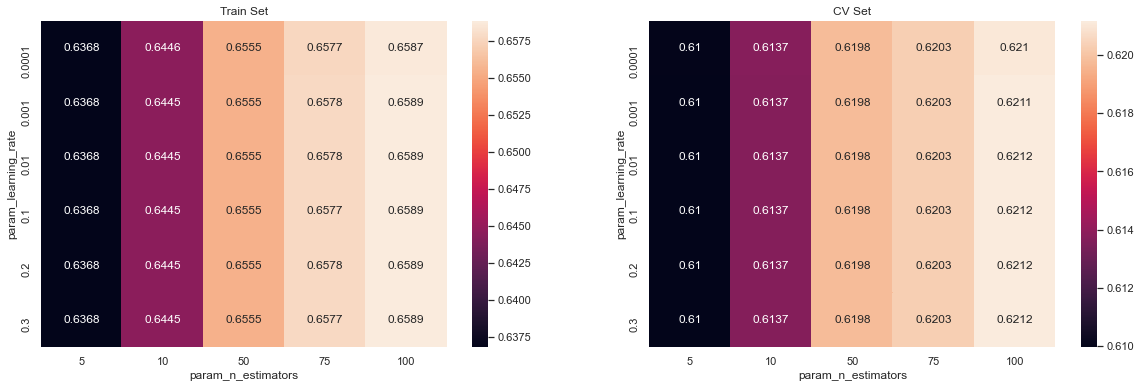

In [ ]:
#referred to https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb for this.

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_learning_rate', 'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [ ]:
#training the model with best hyperparamters
best_clf_tfidf = XGBRFClassifier(learning_rate=0.1, n_estimators=80, max_depth = 10)
best_clf_tfidf.fit(X_tfidf_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=80, n_jobs=0,
                num_parallel_tree=80, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

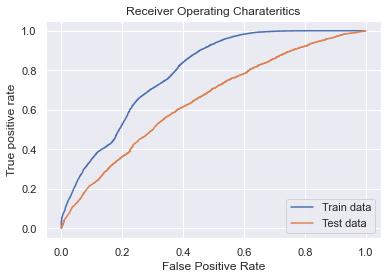

In [ ]:
y_pred_tr = best_clf_tfidf.predict_proba(X_tfidf_train)[:,1]
y_pred_test =  best_clf_tfidf.predict_proba(X_tfidf_test)[:,1]
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train,  y_pred_tr)
fpr1, tpr1, _ = roc_curve(y_test,  y_pred_test)
plt.plot(fpr,tpr, label = 'Train data')
plt.plot(fpr1, tpr1, label = 'Test data')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Charateritics')
plt.show()


Confusion matrix for TFIDF train and test data


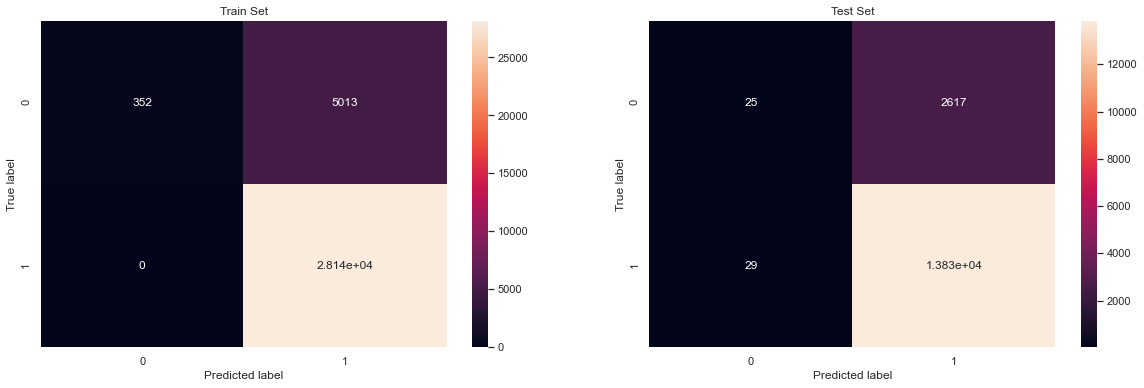

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix for TFIDF train and test data')
import seaborn as sns; sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(confusion_matrix(y_train, best_clf_tfidf.predict(X_tfidf_train)), annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, best_clf_tfidf.predict(X_tfidf_test)), annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
ax[0].set(xlabel = "Predicted label", ylabel = "True label")
ax[1].set(xlabel = "Predicted label", ylabel = "True label")
plt.show()


In [ ]:
len(y_train[y_train == 1])

28135

## Training on W2V vectorized data

In [ ]:
#GBDT_w2v = GradientBoostingClassifier()
#parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [5, 10, 50, 75, 100]}
clf_w2v = GridSearchCV(XGB_tfidf, param , cv=3, scoring='roc_auc',return_train_score=True)
clf_w2v.fit(X_w2v_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=4,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_method=None,
                                       validate_parameters=N

In [ ]:
clf_w2v.best_params_

{'learning_rate': 0.001, 'n_estimators': 50}

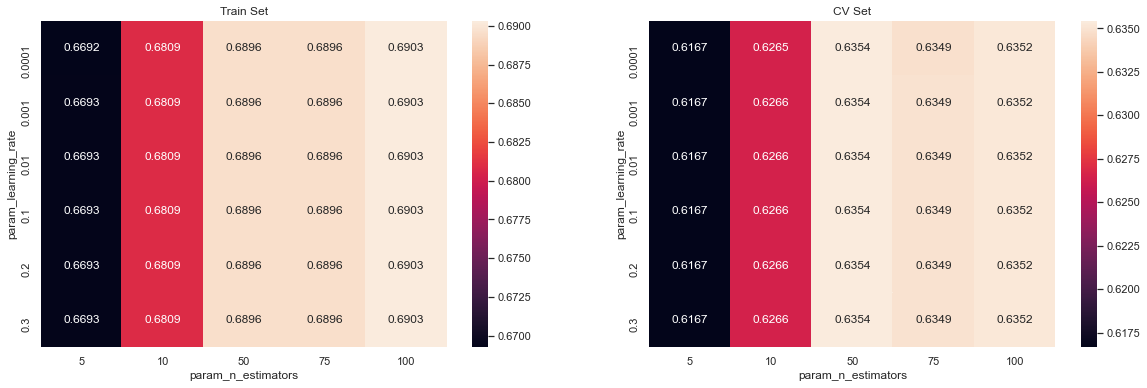

In [ ]:
#referred to https://github.com/shashimanyam/DECISION-TREE-ON-DONORSCHOOSE-DATASET/blob/master/DECISION%20TREE%20ON%20DONORSCHOOSE.ipynb for this.

max_scores2 = pd.DataFrame(clf_w2v.cv_results_).groupby(['param_learning_rate', 'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [ ]:
#training the model with best hyperparamters
best_clf_w2v = XGBRFClassifier(learning_rate=0.001, n_estimators=50, max_depth = 10)
best_clf_w2v.fit(X_w2v_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.001,
                max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=0,
                num_parallel_tree=50, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

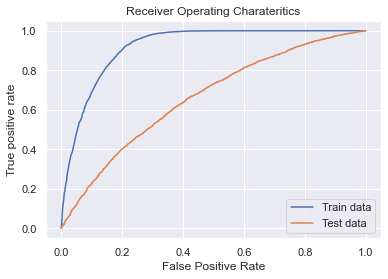

In [ ]:
y_pred_tr = best_clf_w2v.predict_proba(X_w2v_train)[:, 1]
y_pred_test =  best_clf_w2v.predict_proba(X_w2v_test)[:, 1]
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train,  y_pred_tr)
fpr1, tpr1, _ = roc_curve(y_test,  y_pred_test)
plt.plot(fpr,tpr, label = 'Train data')
plt.plot(fpr1, tpr1, label = 'Test data')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Charateritics')
plt.show()


Confusion matrix for W2V train and test data


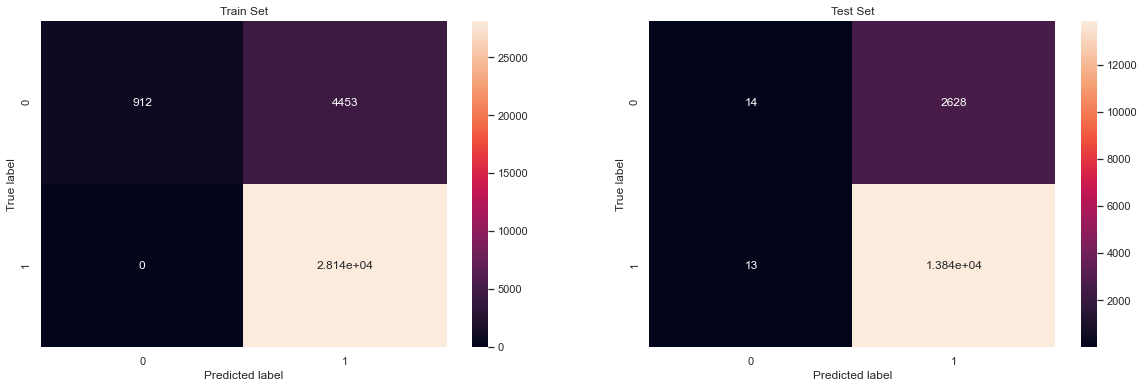

In [ ]:
print('Confusion matrix for W2V train and test data')
import seaborn as sns; sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(confusion_matrix(y_train, best_clf_w2v.predict(X_w2v_train)), annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(confusion_matrix(y_test, best_clf_w2v.predict(X_w2v_test)), annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
ax[0].set(xlabel = "Predicted label", ylabel = "True label")
ax[1].set(xlabel = "Predicted label", ylabel = "True label")
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from prettytable import PrettyTable
TB = PrettyTable()
TB.field_names = ["Vectorizer","Model", "Hyperparameter", "ROC AUC"]
TB.add_row(["TF-IDF", "Decision Tree", "learning_rate = 0.1   | n_estimators = 100", 0.66])
TB.add_row(["TF-IDF Word to Vector", "Decision Tree", "learning_rate = 0.001 | n_estimators = 50", 0.63])
print(TB)

+-----------------------+---------------+--------------------------------------------+---------+
|       Vectorizer      |     Model     |               Hyperparameter               | ROC AUC |
+-----------------------+---------------+--------------------------------------------+---------+
|         TF-IDF        | Decision Tree | learning_rate = 0.1   | n_estimators = 100 |   0.66  |
| TF-IDF Word to Vector | Decision Tree | learning_rate = 0.001 | n_estimators = 50  |   0.63  |
+-----------------------+---------------+--------------------------------------------+---------+
